In [1]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import xgboost as xgb

import phik
from phik.report import plot_correlation_matrix
from phik import report
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows

# Data Preprocessing

In [3]:
df = pd.read_csv('../data_v02/dataset.csv')
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,LE_PM_rol_30,LE_PM_rol_7,LE_PM_min,LE_PM_max,LE_PM_std,doy,lat,lon,IGBP,LE
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,1300.433333,-15.142857,-8091.0,14466.0,8934.811384,144,46.7305,-91.2329,DBF,19.2224
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,1307.633333,3.428571,-8091.0,14466.0,8927.863731,145,46.7305,-91.2329,DBF,24.2024
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,1317.700000,31.142857,-8091.0,14466.0,8938.041316,146,46.7305,-91.2329,DBF,19.4017
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,1322.533333,48.571429,-8091.0,14466.0,8933.245569,147,46.7305,-91.2329,DBF,23.7468
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,1333.066667,74.142857,-8091.0,14466.0,8943.574997,148,46.7305,-91.2329,DBF,42.2603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,-362.966667,-1297.428571,-16360.0,10298.0,9260.157236,254,46.6347,-91.0987,DBF,55.7628
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,-420.000000,-87.285714,-16360.0,10298.0,9266.910797,256,46.6347,-91.0987,DBF,31.6040
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,-413.800000,-70.142857,-16360.0,10298.0,9262.322928,257,46.6347,-91.0987,DBF,54.2463
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,-400.900000,-13.285714,-16360.0,10348.0,9277.527589,258,46.6347,-91.0987,DBF,44.2428


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LE'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

In [5]:
one_hot = pd.get_dummies(X_train.IGBP)
X_train = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
one_hot = pd.get_dummies(X_test.IGBP)
X_test = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)

# XGBoost

### LOGS:
**Stratified by IGBP:**

R2: 0.987	RMSE: 4.577	MAE: 1.26

In [13]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 9, 11, 14],
    'min_child_weight': [5, 9, 13],
    'gamma': [0.2, 0.4, 0.6]
}

param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

best_score = float('inf')
best_params = None

for values in param_combinations:
    params = dict(zip(param_names, values))
    params.update({
        'n_estimators': 100,
        'colsample_bytree': 0.9,
        'subsample': 0.8,
        'learning_rate': 0.1,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 0,
        'tree_method': 'gpu_hist',  # use 'hist' if CPU
        'n_jobs': -1,
    })

    model =  xgb.XGBRegressor(**params, device="cuda")
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=0
    )

    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Params: {params}")
    print(f"→ R2: {r2:.3f}\tRMSE: {rmse:.3f}\tMAE: {mae:.3f}")

    if rmse < best_score:
        best_score = rmse
        best_params = params.copy()
        print("↑ New best!")

print("\nBest Params:")
print(best_params)
print(f"Best RMSE: {best_score:.3f}")

Params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.2, 'n_estimators': 100, 'colsample_bytree': 0.9, 'subsample': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 'verbosity': 0, 'tree_method': 'gpu_hist', 'n_jobs': -1}
→ R2: 0.931	RMSE: 10.612	MAE: 7.179
↑ New best!
Params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.4, 'n_estimators': 100, 'colsample_bytree': 0.9, 'subsample': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 'verbosity': 0, 'tree_method': 'gpu_hist', 'n_jobs': -1}
→ R2: 0.931	RMSE: 10.612	MAE: 7.179
Params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.6, 'n_estimators': 100, 'colsample_bytree': 0.9, 'subsample': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 'verbosity': 0, 'tree_method': 'gpu_hist', 'n_jobs': -1}
→ R2: 0.931	RMSE: 10.612	MAE: 7.179
Params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.2, 'n_estimators': 100, '

In [6]:
best_params = {'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 5, 'gamma': 0.6, 'n_estimators': 100, 
               'colsample_bytree': 0.9, 'subsample': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 
               'verbosity': 0, 'tree_method': 'gpu_hist', 'n_jobs': -1}

model =  xgb.XGBRegressor(**best_params, device="cuda")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=0
)
    
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"→ R2: {r2:.3f}\tRMSE: {rmse:.3f}\tMAE: {mae:.3f}")

→ R2: 0.973	RMSE: 6.640	MAE: 2.936


In [9]:
model.save_model("../models/xgboost_model.json")

/tmp/ipykernel_2601409/738129701.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi_df.loc[top_features, :], palette='viridis')


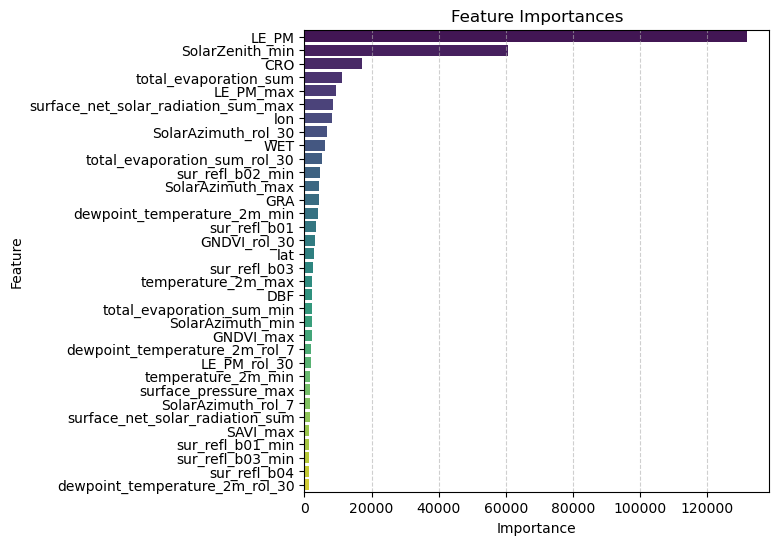

In [35]:
fi_df = pd.DataFrame({
    'feature': model.get_booster().get_score(importance_type='gain').keys(),
    'importance': model.get_booster().get_score(importance_type='gain').values()
})

fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x='importance', y='feature', data=fi_df.loc[top_features, :], palette='viridis')

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [30]:
fi_filt = (fi_df.importance - fi_df.importance.min())/(fi_df.importance.max()-fi_df.importance.min())
fi_filt[fi_filt>0.01].index

Index([19, 77, 153], dtype='int64')

In [34]:
top_features = fi_df.loc[fi_filt[fi_filt>0.01].index.tolist(), :].feature.index.tolist()

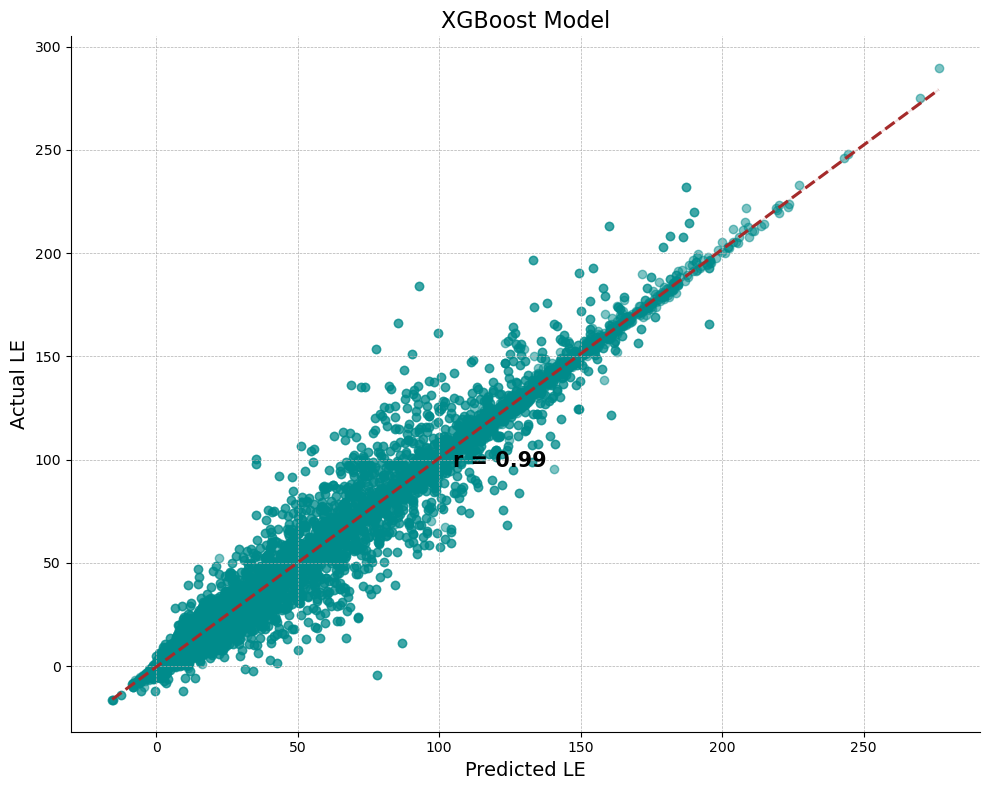

In [37]:
plt.figure(figsize=(10, 8))

ax = sns.regplot(
    x=y_pred,
    y=y_test,
    scatter_kws={'alpha':0.5, 'color':'darkcyan'},
    line_kws={'color':'brown', 'ls': '--'}
)

corr = np.corrcoef(y_pred, y_test)[0, 1]
plt.text(0.42, 0.38, f'r = {corr:.2f}', transform=ax.transAxes, fontsize=15, fontweight='bold')


plt.title('XGBoost Model', fontsize=16)
plt.xlabel('Predicted LE', fontsize=14)
plt.ylabel('Actual LE', fontsize=14)

ax.grid(True, lw=0.5, ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()